# Exploratory Data Analysis 📈

In this notebook, I will be answering some of the research questions about technology accessibility violations specifically targeting various websites belonging to relevant domains such as health, government, news, etc. The research questions I will be tackling are:
- **Which domain categories (health, education, government, etc.) have the highest number of accessibility violations?**
- **What violation types are most common across domains categories?**
- **Which web domain has the most severe accessibility issues?**

There are questions that helps us better understand how accessibility challenges are distributed across different sectors and where users with disabilities may face the greatest barriers when accessing online content. By identifying both the frequency and severity of violations, this analysis highlights systemic patterns rather than isolated issues, offering insight into which domains may require greater regulatory attention, improved design practices, or more robust accessibility testing. Ultimately, answering these questions supports the development of more inclusive web technologies and informs efforts to prioritize accessibility improvements where they are most urgently needed.


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline

### Examine Dataset

In [2]:
df = pd.read_csv("../Data/Access_to_Tech_Dataset.csv")
df.shape

(3524, 17)

In [3]:
df.head()

,id,web_URL_id,domain_category,web_URL,scrape_status,html_file_name,html_file_path,violation_count,violation_name,violation_score,violation_description,violation_description_url,affected_html_elements,violation_category,violation_impact,wcag_reference,supplementary_information
0,700_0,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/buy-from-government\"">How to buy fro...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."
1,700_1,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-banner-is-top-level,3,Ensures the banner landmark is at top level,https://dequeuniversity.com/rules/axe/4.4/land...,"<div class=\usa-banner__header\"" role=\""banner...",Syntax,moderate,['1.3.1 Info and Relationships'],"<div class=\usa-banner__header\"" role=\""banner..."
2,700_2,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-no-duplicate-banner,3,Ensures the document has at most one banner la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],11 <header> or role='banner' elements found:\n...
3,700_3,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-unique,3,Landmarks should have a unique role or role/la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],Role 'search' found 2 times:\n<form accept-cha...
4,701_0,701,Government and Public Services,https://www.usa.gov/benefits,scraped,www_usa_gov_benefits.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/food-help\"">Learn about food assista...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."


## Data Cleaning 🧼

It's important to understand the data types we are working with for every column of the dataset so we know how we should handle those values in cleaning, filtering, and building visualizations for analysis.

> First we make sure we are only working with `scraped` data

In [4]:
df = df[df['scrape_status'] == 'scraped']
df.shape

(3524, 17)

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   id                         3524 non-null   str  
 1   web_URL_id                 3524 non-null   int64
 2   domain_category            3524 non-null   str  
 3   web_URL                    3524 non-null   str  
 4   scrape_status              3524 non-null   str  
 5   html_file_name             3524 non-null   str  
 6   html_file_path             3524 non-null   str  
 7   violation_count            3524 non-null   int64
 8   violation_name             3524 non-null   str  
 9   violation_score            3524 non-null   int64
 10  violation_description      3524 non-null   str  
 11  violation_description_url  3523 non-null   str  
 12  affected_html_elements     3472 non-null   str  
 13  violation_category         3520 non-null   str  
 14  violation_impact           3524 non

In [6]:
total_missing = int(df.isna().sum().sum())
print(f"Currently, there are {total_missing} missing entries in the dataset! We need to bring this number down to 0 before we do anything else!")

Currently, there are 1735 missing entries in the dataset! We need to bring this number down to 0 before we do anything else!


In [7]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

supplementary_information    1678
affected_html_elements         52
violation_category              4
violation_description_url       1
dtype: int64

This is not too difficult to work with! There are only four columns with missing data and all four use str as their data type. For everything except `violation_category`, we will just leave it as an empty string (Important for Machine Learning!). There are only 4 entires missing for `violation_category` which its overall impact on our analysis and visualizations negligible. However, we still have to consider its plausibility for machine learning tasks; the more data the better! Since it is still an important categorical variable, we will impute the missing value by extrapolating from other entries using mode or most common categories these missing entries.  

In [8]:
df['supplementary_information'] = df['supplementary_information'].fillna("")
df['affected_html_elements'] = df['affected_html_elements'].fillna("")
df['violation_category'] = df['violation_category'].fillna(df["violation_category"].mode()[0])
df['violation_description_url'] = df['violation_description_url'].fillna("")

In [9]:
total_missing = int(df.isna().sum().sum())
print(f"We have {total_missing} entries that are missing. If this value isn't 0, we did something wrong!")

We have 0 entries that are missing. If this value isn't 0, we did something wrong!


## Which domain categories (health, education, government, etc.) have the highest number of accessibility violations?

> Before we jump straight to visualization, let's tackle what accessibility domains exist on this dataset!

In [10]:
df['domain_category'].unique()

<StringArray>
[ 'Government and Public Services',                  'News and Media',
 'Technology Science and Research',                      'E-commerce',
           'Educational Platforms',             'Streaming Platforms',
             'Health and Wellness',       'TechnologyScienceResearch',
                       'Ecommerce']
Length: 9, dtype: str

> This proves why EDA is so important. We have accessibility domains that are named differently but mean the same things!
- `TechnologyScienceResearch` -> `Technology Science and Research`
- `Ecommerce` -> `E-commerce`

In [11]:
df['domain_category'] = df['domain_category'].replace('TechnologyScienceResearch', 'Technology Science and Research').replace(\
    'Ecommerce', 'E-commerce')
violation_by_category = df.groupby('domain_category')['violation_count'].sum().sort_values(ascending=False)
violation_by_category

domain_category
News and Media                     8568
Technology Science and Research    4234
Educational Platforms              3985
Streaming Platforms                3161
E-commerce                         2648
Government and Public Services     2310
Health and Wellness                1123
Name: violation_count, dtype: int64

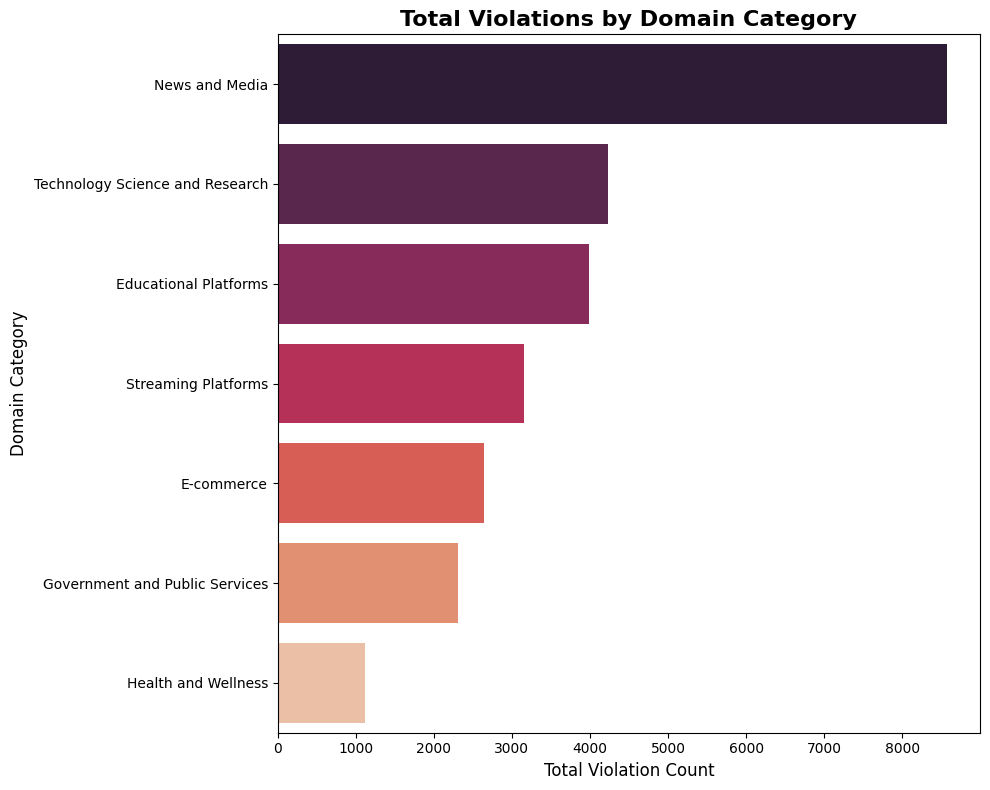

In [12]:
plt.figure(figsize=(10, 8))
sns.barplot(y=violation_by_category.index, x=violation_by_category.values, hue=violation_by_category.index, palette='rocket', legend=False)
plt.title('Total Violations by Domain Category', fontsize=16, fontweight='bold')
plt.xlabel('Total Violation Count', fontsize=12)
plt.ylabel('Domain Category', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
highest_violations_category = violation_by_category.idxmax()
highest_num_violations = violation_by_category.max()
print(f"The {highest_violations_category} has the highest number of accessibility violations amongst all domains in this dataset")
print(f"The total number of violations in {highest_violations_category} is a whopping {highest_num_violations}.")

The News and Media has the highest number of accessibility violations amongst all domains in this dataset
The total number of violations in News and Media is a whopping 8568.


## What violation types are most common across each domain category?

> Again, same idea as above, let's see what violation categories we are working with to ensure different names don't mean the same thing!

In [14]:
df['violation_category'].unique()

<StringArray>
['Layout', 'Syntax', 'Semantic']
Length: 3, dtype: str

In [15]:
violation_comparison = df.groupby(['domain_category', 'violation_category']).size().reset_index(name='count').sort_values(by='count', ascending=False)
violation_comparison

,domain_category,violation_category,count
10,News and Media,Syntax,726
15,Technology Science and Research,Syntax,481
4,Educational Platforms,Syntax,390
12,Streaming Platforms,Syntax,349
6,Government and Public Services,Syntax,303
1,E-commerce,Syntax,272
9,News and Media,Layout,214
13,Technology Science and Research,Layout,168
2,Educational Platforms,Layout,159
8,Health and Wellness,Syntax,117


> First thing we can observe is that most accessibility domain's violation are due to syntax! Let's see if visualization can further shine a light on this phenomenon! 

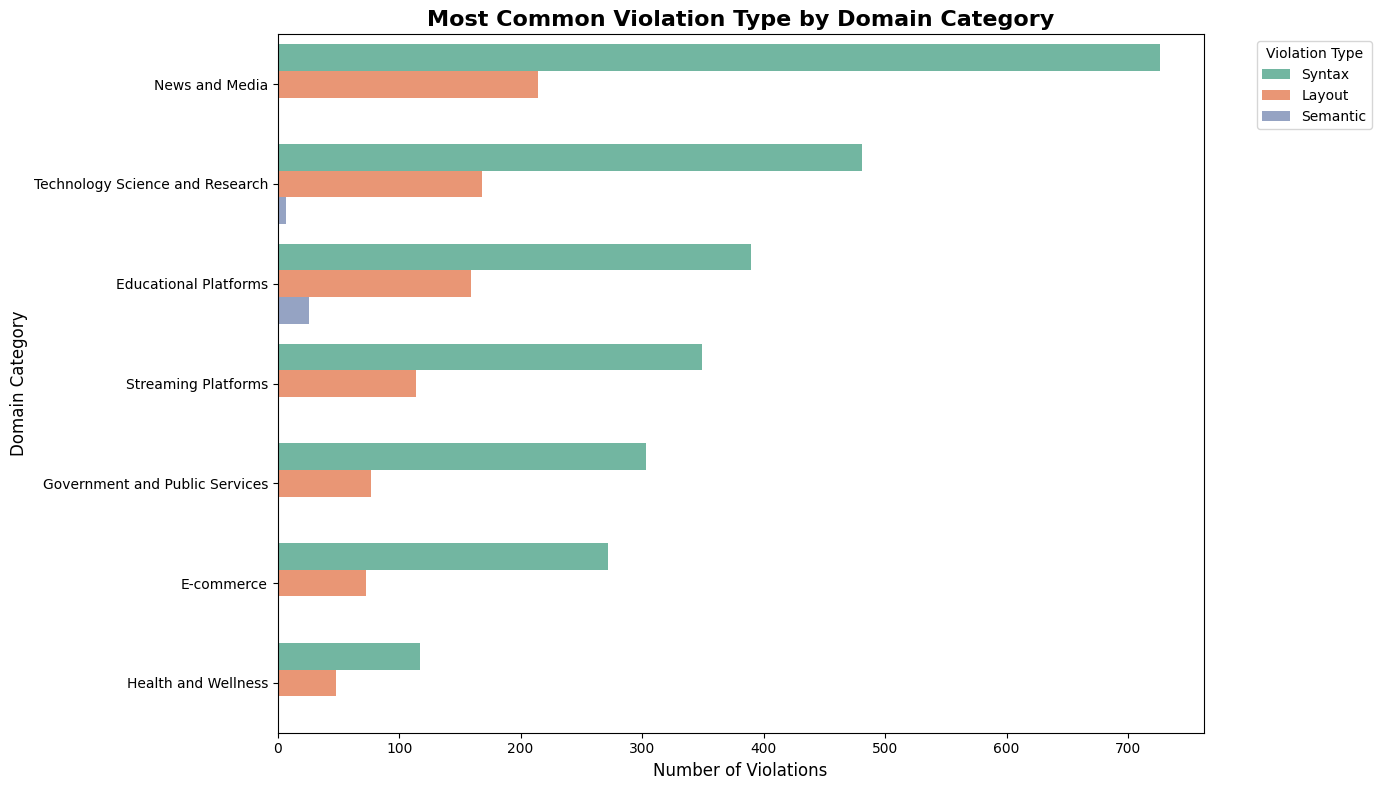

In [16]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=violation_comparison.sort_values('count', ascending=False),
    y='domain_category',
    x='count',
    hue='violation_category',
    palette='Set2',
    legend=True
)
plt.title('Most Common Violation Type by Domain Category', fontsize=16, fontweight='bold')
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('Domain Category', fontsize=12)
plt.legend(title='Violation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
top_violations = violation_comparison.loc[violation_comparison.groupby('domain_category')['count'].idxmax()]
top_violations

,domain_category,violation_category,count
1,E-commerce,Syntax,272
4,Educational Platforms,Syntax,390
6,Government and Public Services,Syntax,303
8,Health and Wellness,Syntax,117
10,News and Media,Syntax,726
12,Streaming Platforms,Syntax,349
15,Technology Science and Research,Syntax,481


It looks like syntax violation is the most common across all accessbility domain and gaps the other violation types by at least double with the most minimal difference in `Health and Wellness` domain.

## Which web domain has the most severe accessibility issues?

This dataset does not have a `web_domain` column so we need to make our own! This can be done with regular expression by transforming `web_URL` to the part we actually want which is the 'www.website.com`.

> Let's test out our regular expression formula below to make sure it works!

In [18]:
url = "https://www.usa.gov/benefits"
clean_url = re.sub(r'^https?://([^/]+).*$', r'\1', url)
# Result: www.usa.gov
print(f"Before Regex: {url}")
print(f"After Regex: {clean_url}")

Before Regex: https://www.usa.gov/benefits
After Regex: www.usa.gov


> Now, we can create our `web_domain` column using those transformations!

In [19]:
df['web_domain'] = df['web_URL'].str.replace(r'^https?://([^/]+).*$', r'\1', regex=True).apply(lambda x: x if x.startswith('www.') else f'www.{x}')
df['web_domain'].unique()

<StringArray>
[             'www.usa.gov',      'www.arstechnica.com',
     'www.newscientist.com',       'www.healthcare.gov',
             'www.kids.gov',       'www.floodsmart.gov',
           'www.popsci.com', 'www.discovermagazine.com',
      'www.theguardian.com',           'www.3dcart.com',
 ...
          'www.the-sun.com',              'www.ansa.it',
        'www.allafrica.com',          'www.metro.co.uk',
            'www.salon.com',    'www.thedailybeast.com',
               'www.nj.com',      'www.bangkokpost.com',
           'www.google.com',          'www.example.com']
Length: 464, dtype: str

> Let's take a look at what violation impact levels are there!

In [20]:
impact_count = df['violation_impact'].value_counts().sort_values(ascending=False)
impact_count

violation_impact
serious     1376
moderate    1273
critical     475
minor        400
Name: count, dtype: int64

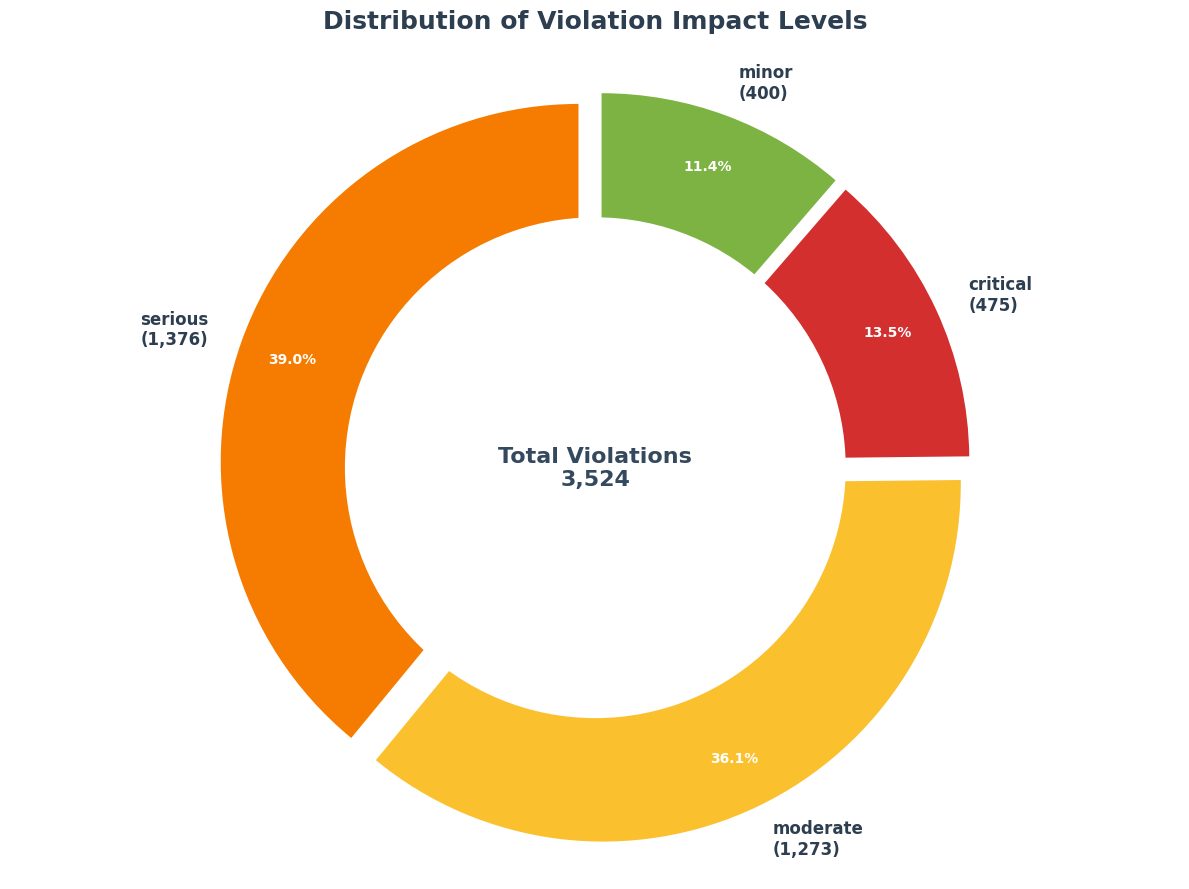

In [21]:
# Custom color mapping based on severity
color_map = {
    'critical': '#d32f2f',    # Dark red
    'serious': '#f57c00',     # Orange
    'moderate': '#fbc02d',    # Yellow
    'minor': '#7cb342',       # Light green
}

# Get colors based on impact level (adjust keys to match your data)
colors = [color_map.get(impact.lower(), '#757575') for impact in impact_count.index]
plt.figure(figsize=(12, 9))

# Create the pie chart
wedges, texts, autotexts = plt.pie(
    impact_count.values, 
    labels=[f'{label}\n({count:,})' for label, count in zip(impact_count.index, impact_count.values)],
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors,
    textprops={'fontsize': 11},
    pctdistance=0.85,
    explode=[0.05] * len(impact_count)  # Slight separation
)

# Style the category labels
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2c3e50')

# Style the percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')
# Create donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.text(0, 0, f'Total Violations\n{impact_count.sum():,}', 
         ha='center', va='center', fontsize=16, weight='bold', color='#34495e')
plt.title('Distribution of Violation Impact Levels', 
          fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
plt.axis('equal')
plt.tight_layout()
plt.show()

Lots of moderate and serious violations! We could say this would be almost normally distributed on a bell curve as most of the violations live in the middle of the impact levels with symmetricity on both ends. 

In [22]:
impact_by_web_domain = df.groupby(['web_domain', 'violation_impact']).size().reset_index(name='count')
impact_by_web_domain.sample(5)

,web_domain,violation_impact,count
150,www.buzzfeednews.com,critical,1
1021,www.springer.com,moderate,3
208,www.codechef.com,serious,3
1212,www.verywellhealth.com,critical,1
137,www.boomplay.com,critical,1


> Pivot Tables are easier on the eye for examining the number of violation impacts for each level across all web domains. And, it will help us build visualizations later on!

In [23]:
impact_pivot = impact_by_web_domain.pivot(
    index='web_domain',
    columns='violation_impact',
    values='count'
).fillna(0).reset_index()

impact_pivot = impact_pivot[['web_domain', 'minor', 'moderate', 'serious', 'critical']]

impact_pivot.columns.name = None

impact_pivot.sample(5)


,web_domain,minor,moderate,serious,critical
48,www.bookwidgets.com,0.00,3.00,3.00,1.00
101,www.dnaindia.com,3.00,5.00,2.00,1.00
232,www.mendeley.com,0.00,1.00,1.00,1.00
145,www.freecodecamp.org,0.00,4.00,2.00,0.00
453,www.woocommerce.com,1.00,1.00,4.00,0.00


### Metric Engineering

The question asks about *severity*, then what is severity? How do we quantify it? Is it the most number of criticals? The most number of violations overall? Below, I crafted a formula for the severity score that not only accounts every violation count across the impact levels but also assigned a weight value given how *impactful is the impact*.

$$\text{Severity Scale} = 0.1 \times \text{minor count} + 0.2 \times \text{moderate count} + 0.3 \times \text{serious count} + 0.4 \times \text{critical count}$$

We can apply this to our new severity column! This will be our key decider of which web domain suffers the most severe accessibility issue!

In [24]:
impact_pivot['severity'] = 0.1 * impact_pivot['minor'] + 0.2 * impact_pivot['moderate'] + 0.3 * impact_pivot['serious'] + 0.4 * impact_pivot['critical']
impact_pivot.sort_values('severity', ascending=False, inplace=True)
impact_pivot.reset_index(drop=True, inplace=True)
impact_pivot.head(10)

,web_domain,minor,moderate,serious,critical,severity
0,www.arstechnica.com,41.00,42.00,83.00,21.00,45.80
1,www.nbcnews.com,10.00,31.00,27.00,21.00,23.70
2,www.pluralsight.com,9.00,18.00,24.00,18.00,18.90
3,www.w3.org,0.00,21.00,26.00,9.00,15.60
4,www.newscientist.com,1.00,40.00,13.00,0.00,12.00
5,www.edx.org,0.00,12.00,18.00,9.00,11.40
6,www.coursera.org,0.00,27.00,18.00,0.00,10.80
7,www.fitbottomedgirls.com,0.00,14.00,13.00,6.00,9.10
8,www.theconversation.com,3.00,12.00,7.00,6.00,7.20
9,www.popsci.com,0.00,5.00,9.00,8.00,6.90


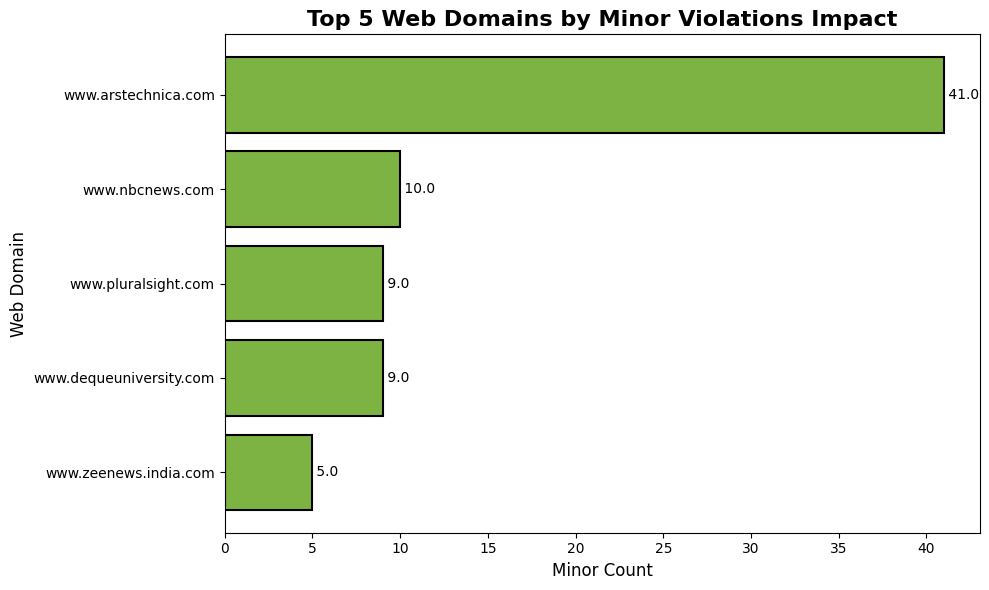

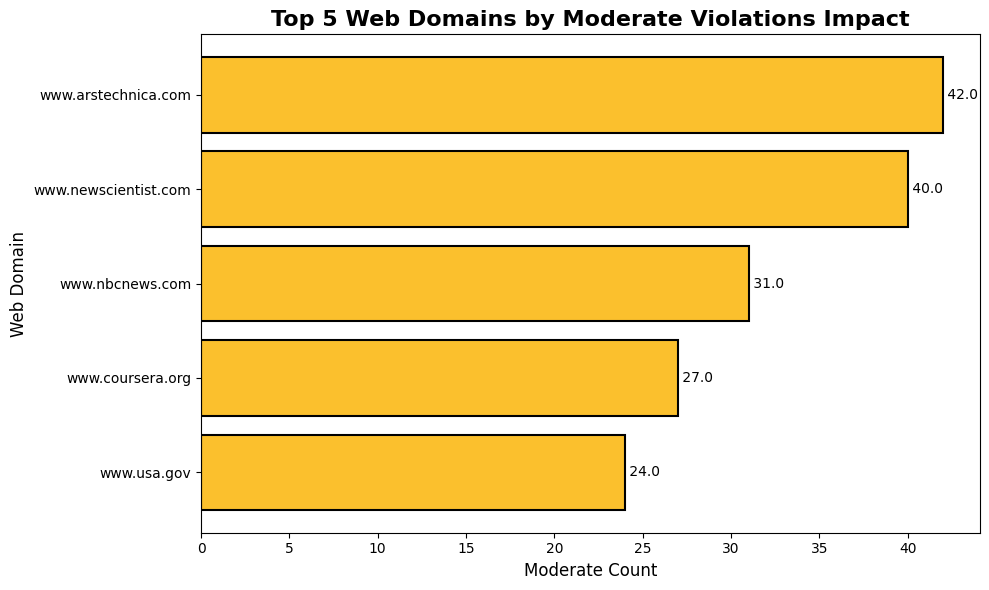

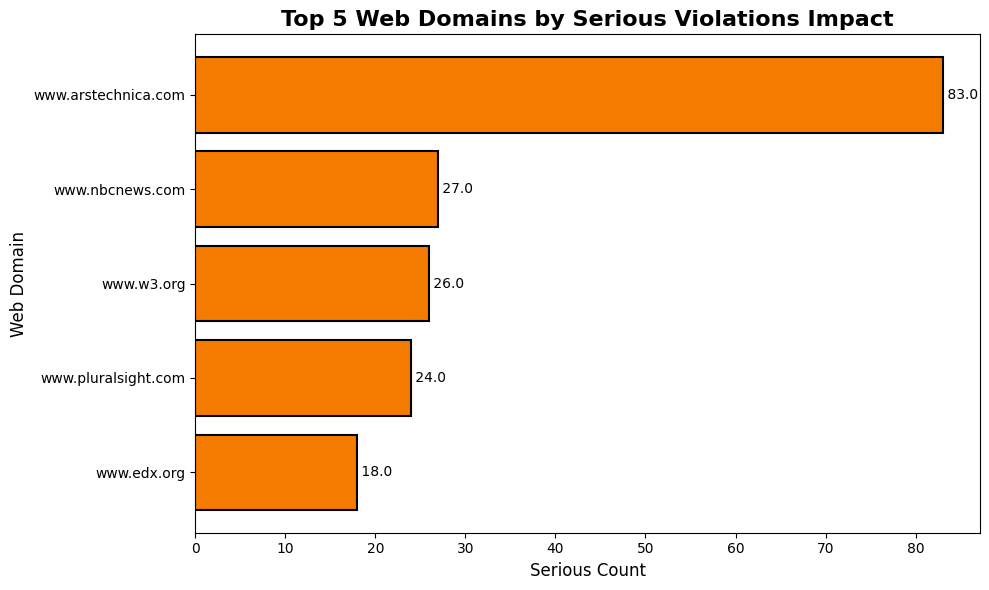

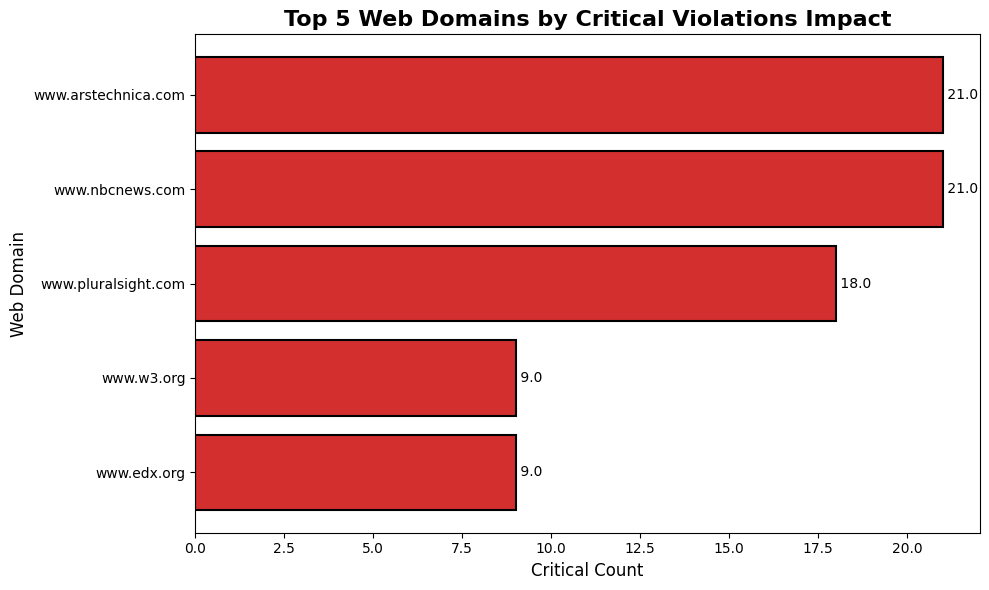

In [25]:
import matplotlib.pyplot as plt

# Define the columns to plot
metrics = ['minor', 'moderate', 'serious', 'critical']
colors = ['#7cb342', '#fbc02d', '#f57c00', '#d32f2f']

# Create a separate plot for each metric
for idx, metric in enumerate(metrics):
    # Sort by the current metric and get top 5
    top_5 = impact_pivot.nlargest(5, metric)
    
    # Create new figure for each plot
    plt.figure(figsize=(10, 6))
    
    # Create horizontal bar chart
    plt.barh(top_5['web_domain'], top_5[metric], 
             color=colors[idx], edgecolor='black', linewidth=1.5)
    
    # Formatting
    plt.title(f'Top 5 Web Domains by {metric.capitalize()} Violations Impact', 
              fontsize=16, fontweight='bold')
    plt.xlabel(f'{metric.capitalize()} Count', fontsize=12)
    plt.ylabel('Web Domain', fontsize=12)
    plt.gca().invert_yaxis()  # Highest at top
    
    # Add value labels on bars
    for i, v in enumerate(top_5[metric]):
        plt.text(v, i, f' {v:.1f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

We observed that `arstechnica` has consistenly ranked top 1 across all impact levels. We can also observe that `nbcnews` are also present in every top 5! Let's see if severity score says otherwise!

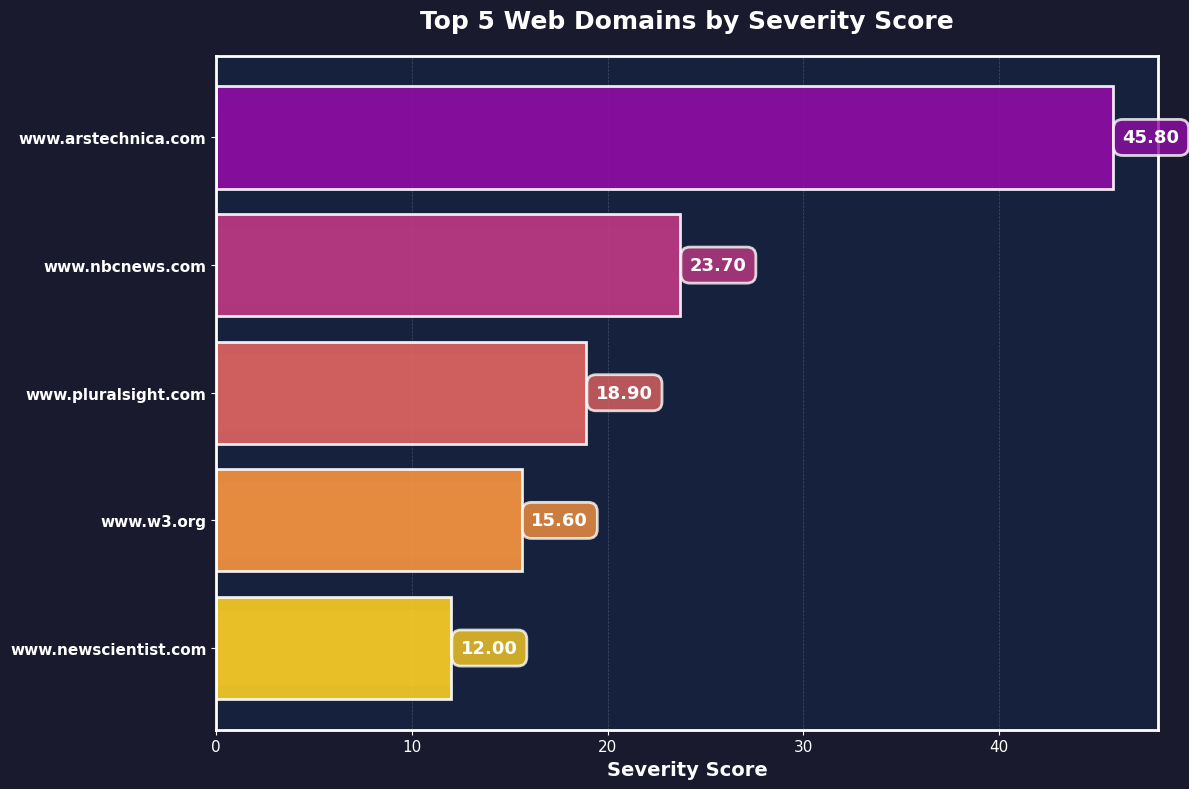

In [26]:
top_5_severity = impact_pivot.nlargest(5, 'severity')

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#1a1a2e')
ax.set_facecolor('#16213e')

colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(top_5_severity)))

bars = ax.barh(range(len(top_5_severity)), top_5_severity['severity'], 
               color=colors, edgecolor='white', linewidth=2, alpha=0.9)

for i, (idx, row) in enumerate(top_5_severity.iterrows()):
    for offset in [0.3, 0.2, 0.1]:
        ax.barh(i, row['severity'], height=0.6, 
                color=colors[i], alpha=offset*0.3, linewidth=0, zorder=0)

ax.set_yticks(range(len(top_5_severity)))
ax.set_yticklabels(top_5_severity['web_domain'], fontsize=11, 
                   color='white', fontweight='bold')

for i, (idx, row) in enumerate(top_5_severity.iterrows()):
    ax.text(row['severity'] + 0.5, i, f"{row['severity']:.2f}", 
            va='center', fontsize=13, color='white', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], 
                     edgecolor='white', linewidth=2, alpha=0.8))

ax.set_xlabel('Severity Score', fontsize=14, color='white', fontweight='bold')
ax.set_title('Top 5 Web Domains by Severity Score', 
             fontsize=18, color='white', fontweight='bold', pad=20)

ax.grid(axis='x', alpha=0.2, color='white', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_color('white')
    spine.set_linewidth(2)

ax.tick_params(colors='white', labelsize=11)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Wow! It seems our assumptions from previous visualizations aren't too far out from what's happening! It turns out, `arstechnica` does have the most severe accessbility issue followed by `nbcnews`! What's also interesting is that the severity score of `arstechnica` almost doubles that of second place, raising real accessbility concerns on their web dev practices!

## Export Cleaned Data

> We can reuse the work we've done here to tackle more complex problems! *Wink* *Wink* mAchIne LeArNing... 

In [27]:
df.to_csv(r'c:\Users\Jia Chen\Downloads\Projects\Datathon_2026\Data\Cleaned_Access_to_Tech_Dataset.csv', index=False)